# Data Quality Checks

In [171]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import importlib

In [172]:
# import OpenEphys tools for Python3
oep = importlib.import_module("analysis-tools.Python3.OpenEphys")

# Load data

In [173]:
datadir = 'data/'
signal_chans = [1, 2, 3, 4, 12, 13, 14, 15]
REF_CHAN = 16

In [174]:
channel = signal_chans[0]

In [175]:
fname = datadir + '100_CH{}.continuous'.format(channel)
reffname = datadir + '100_CH{}.continuous'.format(REF_CHAN)

In [176]:
dat_dict = oep.load(fname)

Loading continuous data...


/Users/jmxp/code/analysis-tools/Python3/OpenEphys.py:128: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  samples = np.zeros(MAX_NUMBER_OF_CONTINUOUS_SAMPLES, dtype)
/Users/jmxp/code/analysis-tools/Python3/OpenEphys.py:129: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  timestamps = np.zeros(MAX_NUMBER_OF_RECORDS)
/Users/jmxp/code/analysis-tools/Python3/OpenEphys.py:130: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  recordingNumbers = np.zeros(MAX_NUMBER_OF_RECORDS)
/Users/jmxp/code/analysis-tools/Python3/OpenEphys.py:157: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  data = np.fromfile(f,np.dtype('>i2'),N) * float(header['bitVolts']) # big-endian 16-bit signed integer, multiplied by bitVolts


In [177]:
dat_dict

{'data': array([-28.665,   7.8  ,   7.8  , ...,   6.825,   4.68 ,   7.8  ]),
 'header': {' date_created': "'16-Aug-2016 184025'",
  ' header_bytes': '1024',
  ' version': '0.4',
  'bitVolts': '0.195',
  'blockLength': '1024',
  'bufferSize': '1024',
  'channel': "'CH1'",
  'channelType': "'Continuous'",
  'description': "'each record contains one 64-bit timestamp, one 16-bit sample count (N), 1 uint16 recordingNumber, N 16-bit samples, and one 10-byte record marker (0 1 2 3 4 5 6 7 8 255)'",
  'format': "'Open Ephys Data Format'",
  'sampleRate': '30000'},
 'recordingNumber': array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.]),
 'timestamps': array([ 7677000.,  7678024.,  7679048.,  7680072.,  7681096.,  7682120.,
        

In [178]:
dat = dat_dict['data']

In [179]:
dat.shape, dat

((57344,), array([-28.665,   7.8  ,   7.8  , ...,   6.825,   4.68 ,   7.8  ]))

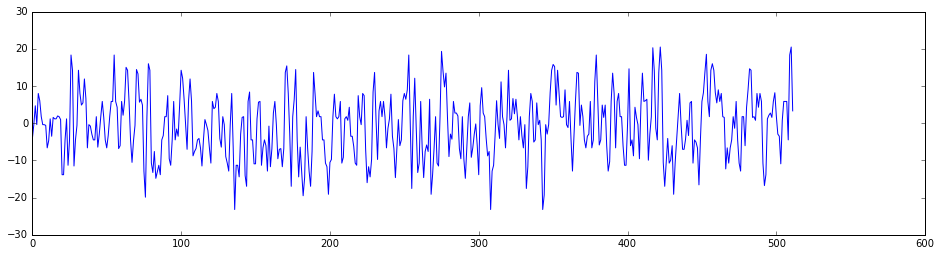

In [180]:
offset = 2048
length = 512
plt.figure(figsize=(16, 4))
plt.plot(dat[offset:(offset+length)])

In [181]:
reffname = datadir + '100_CH{}.continuous'.format(REF_CHAN)
ref_dict = oep.load(reffname)
ref_dat = ref_dict['data']

Loading continuous data...


/Users/jmxp/code/analysis-tools/Python3/OpenEphys.py:128: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  samples = np.zeros(MAX_NUMBER_OF_CONTINUOUS_SAMPLES, dtype)
/Users/jmxp/code/analysis-tools/Python3/OpenEphys.py:129: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  timestamps = np.zeros(MAX_NUMBER_OF_RECORDS)
/Users/jmxp/code/analysis-tools/Python3/OpenEphys.py:130: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  recordingNumbers = np.zeros(MAX_NUMBER_OF_RECORDS)
/Users/jmxp/code/analysis-tools/Python3/OpenEphys.py:157: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  data = np.fromfile(f,np.dtype('>i2'),N) * float(header['bitVolts']) # big-endian 16-bit signed integer, multiplied by bitVolts


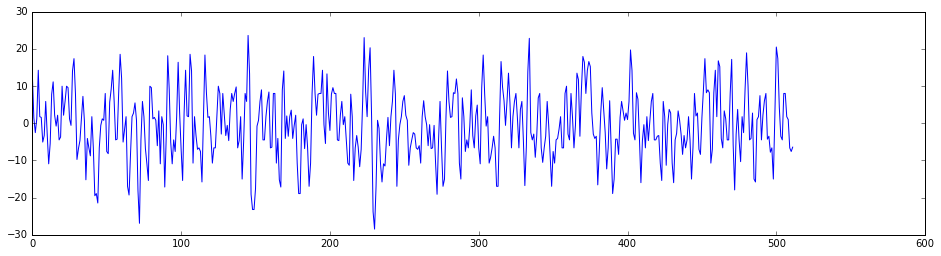

In [182]:
offset = 2048
length = 512
plt.figure(figsize=(16, 4))
plt.plot(ref_dat[offset:(offset+length)])

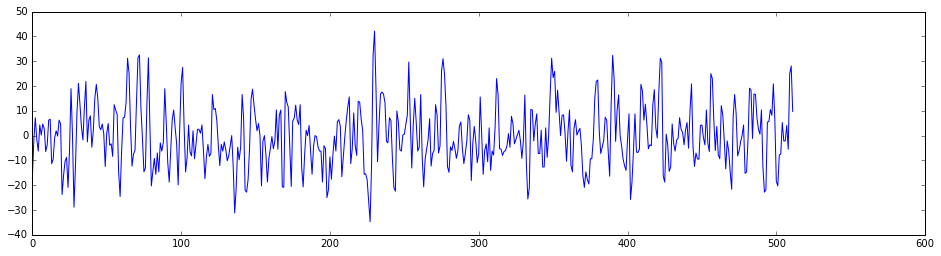

In [183]:
offset = 2048
length = 512
plt.figure(figsize=(16, 4))
plt.plot((dat - ref_dat)[offset:(offset+length)])

Reference signal by subtracting reference wire input

In [184]:
dat = dat - ref_dat

In [185]:
import scipy.signal as ssig

In [186]:
fs = int(dat_dict['header']['sampleRate'])

In [187]:
def bandlimit(df, band=(0.01, 600)):
    """
    Computes bandpass-filtered version of time series in df.
    Band is either a two-element indexed sequence or a conventionally
    defined electrophysiological frequency band.
    """
    dt = 1/fs

    b, a = ssig.iirfilter(2, [2 * dt * f for f in band], rp=0.1, rs=40,
        ftype='ellip')
    return ssig.filtfilt(b, a, df)

In [188]:
def decimate(x, decfrac, axis=-1):
    """
    just like in the scipy source code, except I use filtfilt
    and opt for hardcode defaults
    q is the fraction to decimate by; length of returned data is len(x)/q
    """
    if decfrac > 15:
        wrnstr = """You are attempting to decimate by a factor > 15. You are risking numerical instability. Consider performing multiple successive decimations instead."""
        warnings.warn(wrnstr)

    n = 8
    b, a = ssig.filter_design.cheby1(n, 0.05, 0.8 / decfrac)

    y = ssig.filtfilt(b, a, x, axis=axis)

    sl = [slice(None)] * y.ndim
    sl[axis] = slice(None, None, decfrac)
    return y[sl]

In [189]:
dat = bandlimit(dat)

In [190]:
dat = decimate(decimate(dat, 10), 5)[1:]
dat -= np.mean(dat)

In [191]:
Ns = len(dat)
fs /= 50 # because we downsampled by 50
dt = 1/fs
T = Ns * dt
fmin = 1/(2 * T)
fmax = fs/2
print(fmin)

0.2617801047120419


In [192]:
T

1.9100000000000001

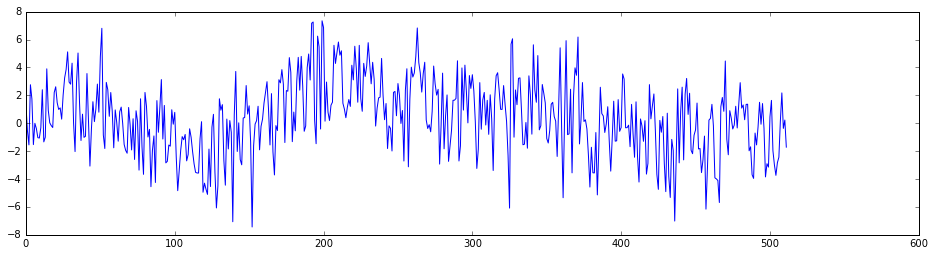

In [193]:
offset = 0
length = 512
plt.figure(figsize=(16, 4))
plt.plot(dat[offset:(offset+length)])

In [194]:
psd = ssig.welch(dat, fs=fs, nperseg=256)

Plot power spectral density

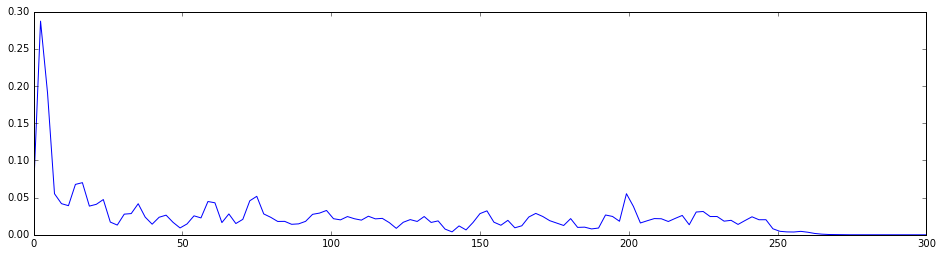

In [195]:
plt.figure(figsize=(16, 4))
plt.plot(psd[0], psd[1])

Plot PSD in dB:

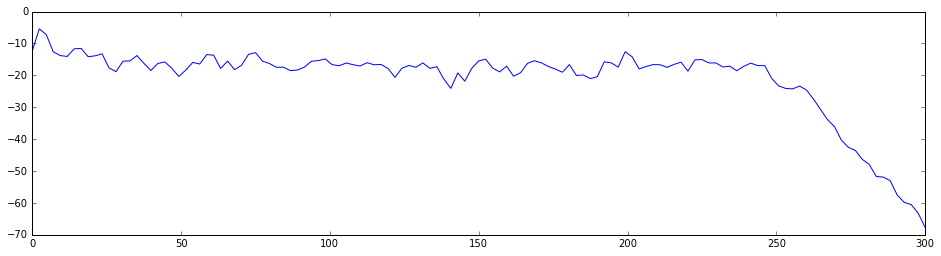

In [196]:
plt.figure(figsize=(16, 4))
plt.plot(psd[0], 10*np.log10(psd[1]))

# Subtract reference wire